In [1]:
import pandas as pd
import numpy as np
import model as deep
import experiment as exp
import myutil as util

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import importlib
importlib.reload(deep)
importlib.reload(exp)

<module 'experiment' from 'c:\\Users\\kyeongtaek\\generative_model\\image_segment\\experiment.py'>

In [2]:
#파일 읽기
filepath_german_csv = 'segment.csv'
d_german_df = pd.read_csv(filepath_german_csv)

#numpy 변환
d_german_np = np.array(d_german_df)

# sample 수, 특징 수 등 계산
n_row = d_german_np.shape[0]
n_features = d_german_np.shape[1]-1

# 입력과 출력 데이터 분리
x = d_german_np[:, :n_features]
y = d_german_np[:, n_features]-1

#정규화
x_norm = (x - np.min(x,0))/ (np.max(x,0) - np.min(x,0))
y_norm = (y - np.min(y,0))/ (np.max(y,0) - np.min(y,0))

C:\Users\kyeongtaek\AppData\Local\Temp\ipykernel_34240\1936844828.py:17: RuntimeWarning: invalid value encountered in divide
  x_norm = (x - np.min(x,0))/ (np.max(x,0) - np.min(x,0))


In [7]:
np.unique(y)

array([0., 1., 2., 3., 4., 5., 6.])

8/8 [==============================] - 0s 11ms/step
0/10	 test_acc:0.948051948051948


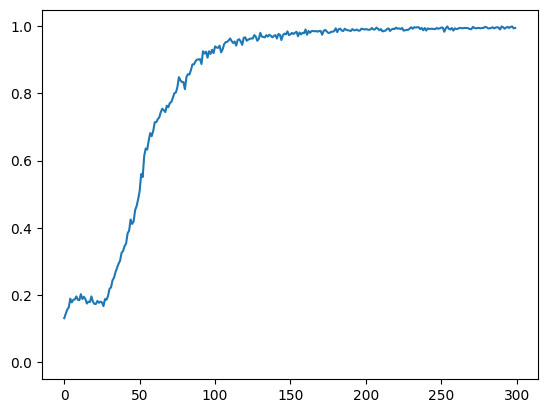

8/8 [==============================] - 0s 2ms/step
1/10	 test_acc:0.948051948051948


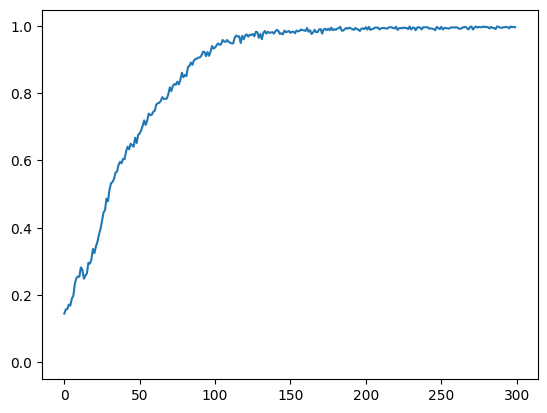

8/8 [==============================] - 0s 2ms/step
2/10	 test_acc:0.9783549783549783


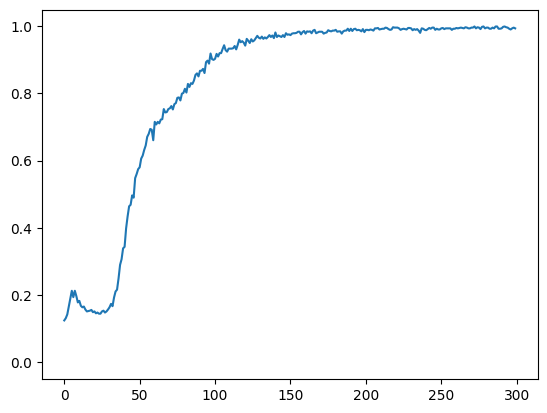

8/8 [==============================] - 0s 2ms/step
3/10	 test_acc:0.9653679653679653


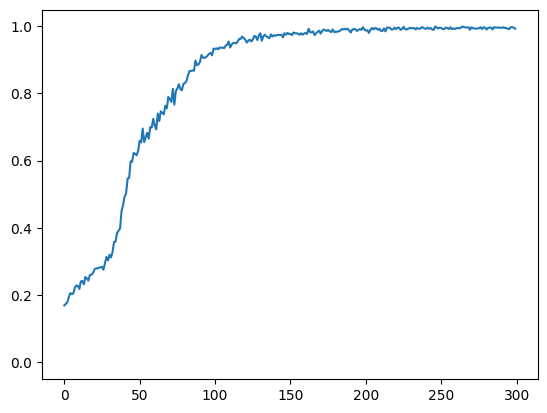

8/8 [==============================] - 0s 2ms/step
4/10	 test_acc:0.961038961038961


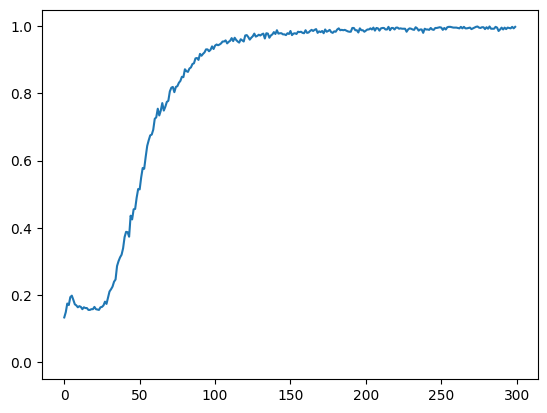

8/8 [==============================] - 0s 2ms/step
5/10	 test_acc:0.974025974025974


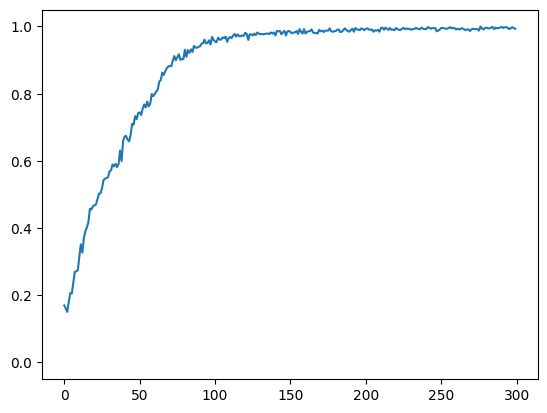

8/8 [==============================] - 0s 2ms/step
6/10	 test_acc:0.9393939393939394


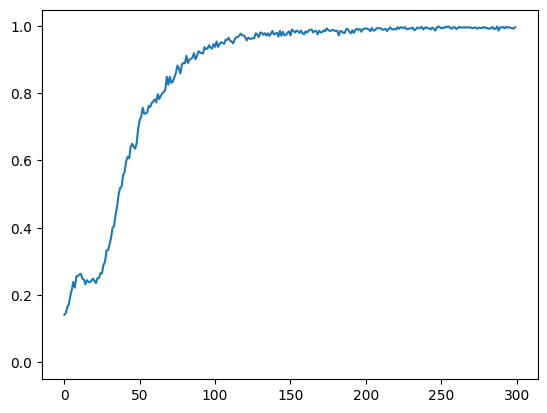

8/8 [==============================] - 0s 2ms/step
7/10	 test_acc:0.9047619047619048


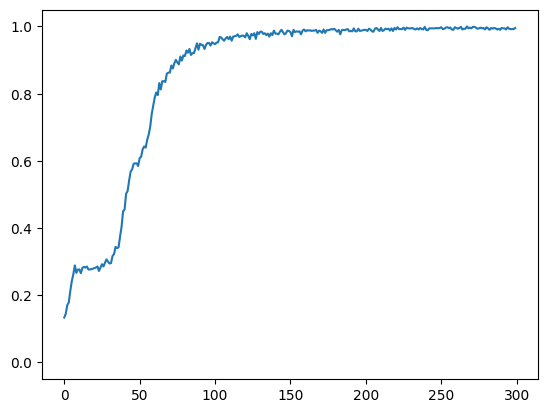

8/8 [==============================] - 0s 3ms/step
8/10	 test_acc:0.9307359307359307


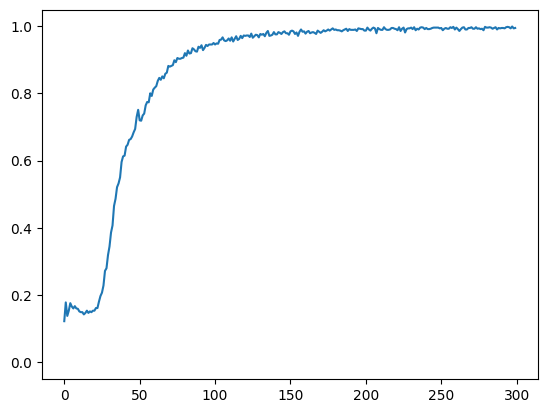

8/8 [==============================] - 0s 3ms/step
9/10	 test_acc:0.9264069264069265


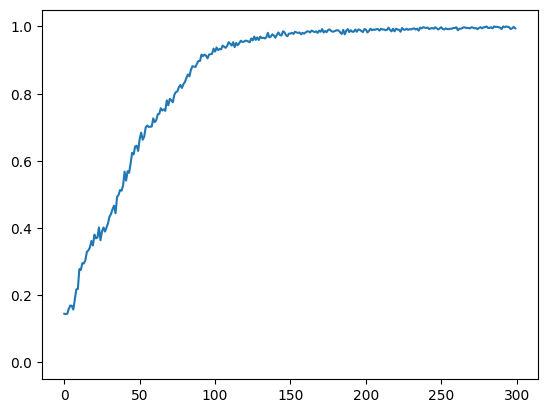

average accuracy : 0.9476190476190476


In [3]:
# 10fold validation 수행여부
bTenFoldValidation = True
if not bTenFoldValidation:  # 학습 & 테스트를 1회만 수행하는 경우
    # 데이터 분할
    [x_train, x_val, x_test, y_train, y_val, y_test] = exp.split_data(x, y, test_ratio=0.0, val_ratio=0.1)

    # 모델 불러오기 & 컴파일
    m = deep.get_model_gen(x.shape[1:])
    m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # 학습시 사용하는 옵션
    train_options = exp.TrainParams(m, epochs=500, batch_size_per_class=32)

    # 학습
    result = exp.train_batches_with_random_selection(train_options, x_train, y_train, x_val, y_val)

    # 테스트
    if(x_test.shape[0] > 0):
        test_acc_tmp = np.sum(np.argmax(np.squeeze(result.model.predict(x_test)), -1) == y_test) / y_test.shape[0]
        print(f'test_acc:{test_acc_tmp}')
    # 결과 출력

    plt.plot(result.train_acc)
    plt.plot(result.val_acc)
    plt.show()

else:  # N fold Validation
    idx = np.array(range(n_row))
    np.random.shuffle(idx)  # 데이터 인덱스 섞기

    N = 10
    total = 0
    nClass = 7
    cm_sum = np.zeros([nClass, nClass])
    for i in range(N):
        # Train/Test 데이터 분할
        [x_train, x_test, y_train, y_test] = exp.split_data_for_N_fold_validation(x, y, fold=N, idx=i)

        # 모델 불러오기 & 컴파일
        m = deep.get_model_gen(x.shape[1:])
        #m = deep.get_model(x.shape[1:])

        # m = deep.get_model(x.shape[1:])
        m.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

        # 학습시 사용하는 옵션
        train_options = exp.TrainParams(m, epochs=300, batch_size_per_class=128)

        # 학습
        result = exp.train_batches_with_random_selection(train_options, x_train, y_train, bVerbose=False)

        # 테스트
        o = np.argmax(np.squeeze(result.model.predict(x_test)), -1)
        test_acc_tmp = np.sum(o == y_test) / y_test.shape[0]
        cm = np.zeros([nClass, nClass])
        for j in range(y_test.shape[0]):
            cm[int(y_test[j]), int(o[j])] += 1  #Confusion Matrix 계산
        cm_sum += cm

        # 결과 출력
        print(f'{i}/{N}\t test_acc:{test_acc_tmp}')
        plt.plot(result.train_acc)
        plt.plot(result.val_acc)
        plt.show()
        total = total + test_acc_tmp

ave = total/10
print(f'average accuracy : {ave}')

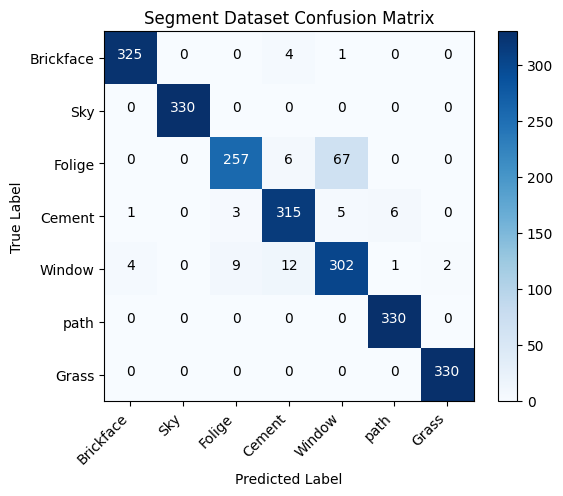

In [4]:
conf_matrix = cm_sum
# 시각화
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Segment Dataset Confusion Matrix')
plt.colorbar()

classes = ['Brickface', 'Sky', 'Folige', 'Cement', 'Window', 'path', 'Grass']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 각 셀에 숫자 표시
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(int(conf_matrix[i, j])),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

In [4]:
m.save('segment_model.h5')

In [4]:
import tensorflow as tf

  # 모델 불러오기
load_model = tf.keras.models.load_model('segment_model.h5')

In [5]:
import tensorflow as tf
cam_model = tf.keras.Model(load_model.input, outputs=(load_model.layers[-17].output, load_model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27_input (InputLayer)  [(None, 19)]             0         
                                                                 
 dense_27 (Dense)            (None, 1600)              32000     
                                                                 
 batch_normalization_27 (Bat  (None, 1600)             6400      
 chNormalization)                                                
                                                                 
 reshape_9 (Reshape)         (None, 5, 5, 64)          0         
                                                                 
 up_sampling2d_27 (UpSamplin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 10, 10, 32)        18464 

In [6]:
get_output = tf.keras.backend.function([load_model.layers[0].input],
                                       [load_model.layers[-17].output, load_model.layers[-1].output])
[conv_outputs, cam_predictions] = get_output([x_test])
class_weights = load_model.layers[-1].get_weights()[0]

In [43]:
final_img = np.squeeze(conv_outputs[22])

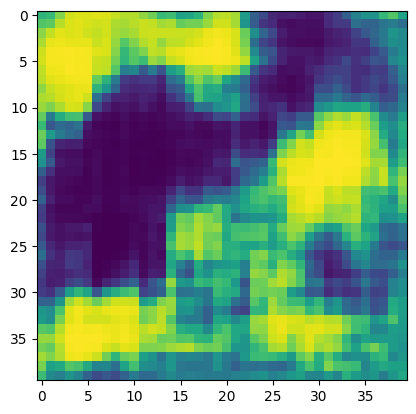

In [44]:
from matplotlib.pyplot import imshow

imshow(final_img)